# Manipulating Data for the Road Map Project
Author: Nicholas Hunt-Walker<br/>
Date: 3/16/2015 (Updated: 3/27/2015)

This is a Notebook detailing how you could have interactions with the database and the analysis of your data all taking place in one space, instead of scattering scripts and programs and files hither and thither. There's a couple of sections here, so I'm providing some symbolic links for you to use to jump through the notebook as you please. Feel free to contact me with any questions at nhuntwalker@gmail.com

The data is sourced from the <a href="http://www.k12.wa.us/DataAdmin/default.aspx">State of Washington Office of Superintendent of Public Instruction</a> 

<ul>
<li>Database Functions (<a href="#Database-Functions">here</a>)</li>
<li>State and County Aggregate Files are Loaded Straight from Excel Spreadsheets (<a href="#State-Aggregate-Files">here</a>)</li>
<li>Data Tables for Each Aggregate File (<a href="#Creating-Data-Tables">here</a>)</li>
<li>The Loaded Information is Retrieved (<a href="#Retrieving-Info-From-Tables">here</a>)</li>
<li>Some Aspects of the Data are Visualized (<a href="#Visualize-The-Data">here</a>)</li>
</ul>

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import MySQLdb
import time
import os
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import LineCollection
from matplotlib import cm
import shapefile
import inspect
from itertools import islice, izip

In [2]:
db_inputs = {"host":"localhost", "user":"root", "password":"root"}
db = MySQLdb.connect(host=db_inputs["host"], user=db_inputs["user"], passwd=db_inputs["password"], port=8889)
cursor = db.cursor()

## Database Functions

In [3]:
def create_database(dbname):
    sql1 = "SHOW DATABASES;"
    cursor.execute(sql1)
    current_databases = np.concatenate(cursor.fetchall())
    if dbname not in current_databases:
        sql2 = "CREATE DATABASE %s;" % dbname
        cursor.execute(sql2)
        print "Database %s created at %s" % (dbname, time.strftime("%D %H:%M:%S"))
        
    else:
        print "Database '%s' already exists." % dbname

In [4]:
def delete_database(dbname):
    sql1 = "SHOW DATABASES;"
    cursor.execute(sql1)
    current_databases = np.concatenate(cursor.fetchall())
    if dbname in current_databases:
        sql2 = "DROP DATABASE %s;" % dbname
        cursor.execute(sql2)
        print "Database '%s' deleted at %s" % (dbname, time.strftime("%D %H:%M:%S"))
        
    else:
        print "'%s' does not exist." % dbname

In [5]:
def create_table(tbname, dbname, column_names, dtypes, quiet=False):
    sql1 = "SHOW TABLES IN %s;" % dbname
    cursor.execute(sql1)
    current_tables = cursor.fetchall()
    
    if (len(current_tables) == 0) or ((len(current_tables) > 0) & (tbname not in np.concatenate(current_tables))):    
        sql2 = "CREATE TABLE %s.%s (" % (dbname, tbname)
        sql2 += "%s %s" % (column_names[0], dtypes[0])
        for ii in range(1, len(column_names)):
            sql2 += ", %s %s" % (column_names[ii], dtypes[ii])
        
        sql2 += ");"

        cursor.execute(sql2)
        if quiet==False:
            print "Table %s created in database %s at %s" % (tbname, dbname, time.strftime("%D %H:%M:%S"))
       
    else:
        if quiet==False:
            print "Table %s in database %s already exists." % (tbname, dbname)

In [6]:
def delete_table(tbname, dbname):
    sql1 = "SHOW TABLES IN %s;" % dbname
    cursor.execute(sql1)
    current_tables = np.concatenate(cursor.fetchall())
    if tbname in current_tables:
        sql2 = "DROP TABLE %s.%s;" % (dbname, tbname)
        cursor.execute(sql2)
        print "Table '%s' in database '%s' deleted at %s" % (tbname, dbname, time.strftime("%D %H:%M:%S"))
        
    else:
        print "'%s' does not exist in database %s." % (tbname, dbname)

In [7]:
def load_data_to_new_table(filename, dbname, tbname=None, print_sql=False):
    if not tbname:
        tbname = filename.split(".")[0].replace("-","_").lower()
    
    the_data = pd.read_csv(filename)
    nohead_fname = filename.split(".")[0]+"_no_head.csv"
    the_data.to_csv(nohead_fname, header=False, index=False, sep="\t")
    column_names = list(the_data.columns)
    dtypes = []
    
    for ii in range(len(column_names)):
        if the_data[column_names[ii]].dtype == "O":
            dtypes.append("VARCHAR(100)")
        elif the_data[column_names[ii]].dtype == "int64":
            dtypes.append("INT")
        column_names[ii] = column_names[ii].lower().replace(" ","_")
    
    # Create the table
    create_table(tbname, dbname, column_names, dtypes)
    
    # Load the data
    sql = "LOAD DATA LOCAL INFILE '%s/%s' INTO TABLE %s.%s FIELDS TERMINATED BY '\\t' (%s" % (os.getcwd(), nohead_fname, dbname, tbname, column_names[0])
    for ii in range(1, len(column_names)):
        sql += ", %s" % column_names[ii]
    
    sql += ");"
    
    if print_sql == False:
        cursor.execute(sql)
    
    else:
        sql_file = open("load_data.sql", "w")
        sql_file.write(sql)
        sql_file.close()
        os.system("mysql -u %s --password=%s < load_data.sql" % (db_inputs["user"], db_inputs["password"]))
        os.system("rm load_data.sql")
    
    print "\nData from %s loaded into %s.%s at %s" % (filename, dbname, tbname, time.strftime("%D %H:%M:%S"))

In [8]:
def load_state_aggregate_data(filename, dbname, print_sql=False, skiprows=3, quiet=False, sheetname=0):
    data_year = filename.split(".")[0][-4:]
    tbname = "state_aggregate_"+data_year
    
    the_data = pd.read_excel(filename, skiprows=skiprows, sheetname=sheetname)
    nohead_fname = tbname+"_no_head.tsv"
    the_data.to_csv(nohead_fname, header=False, index=False, sep="\t")
    column_names = list(the_data.columns)
    dtypes = []
    
    if "Year 1" in column_names:
        for ii in range(len(column_names)):
            if the_data[column_names[ii]].dtype == "O":
                dtypes.append("VARCHAR(100)")
            elif the_data[column_names[ii]].dtype == "int64":
                dtypes.append("INT")
            elif the_data[column_names[ii]].dtype == "float64":
                dtypes.append("DOUBLE")
            column_names[ii] = column_names[ii].lower().replace(" ","_").replace("-","_")
            if column_names[ii].startswith("year"):
                column_names[ii] = column_names[ii]+"_dropouts"
            if column_names[ii].find("actual") > -1:
                column_names[ii] = "adjusted_4_year_cohort_graduation_rate"
    
    else:
        for ii in range(len(column_names)):
            if the_data[column_names[ii]].dtype == "O":
                dtypes.append("VARCHAR(100)")
            elif the_data[column_names[ii]].dtype == "int64":
                dtypes.append("INT")
            elif the_data[column_names[ii]].dtype == "float64":
                dtypes.append("DOUBLE")

            if column_names[ii] == "Category":
                column_names[ii] = "Student " + column_names[ii]
            if type(column_names[ii]) == int:
                column_names[ii] = "Net Students Served in Grade "+str(column_names[ii])
            if column_names[ii].find(".1") > -1:
                column_names[ii] = "Grade "+ column_names[ii].split(".")[0] + " Dropouts"
            if column_names[ii].find(".2") > -1:
                column_names[ii] = "Grade "+ column_names[ii].split(".")[0] + " Dropout Rate"
            if (column_names[ii] == "Number") or (column_names[ii] == "Count"):
                column_names[ii] = "Number Continuing" 
            if column_names[ii] == "Rate":
                column_names[ii] = "Rate Continuing" 
            if column_names[ii].startswith("Start"):
                column_names[ii] = "Percent Remaining " + column_names[ii]
            if column_names[ii].endswith("(minus continuing)"):
                column_names[ii] = column_names[ii].split("(")[0]
            if column_names[ii].find("Est") > -1:
                column_names[ii] = column_names[ii].replace("Est","Estimated") + " Rate"
            if column_names[ii].startswith("Annual"):
                column_names[ii] = column_names[ii] + " Rate"
            column_names[ii] = column_names[ii].lower().replace(" ","_").replace("-","_").replace("*","")        
        
    # Create the table
    create_table(tbname, dbname, column_names, dtypes, quiet=quiet)
    
    # Load the data
    sql = "LOAD DATA LOCAL INFILE '%s/%s' INTO TABLE %s.%s FIELDS TERMINATED BY '\\t' (%s" % (os.getcwd(), nohead_fname, dbname, tbname, column_names[0])
    for ii in range(1, len(column_names)):
        sql += ", %s" % column_names[ii]
    
    sql += ");"
    
    if print_sql == False:
        cursor.execute(sql)
    
    else:
        sql_file = open("load_data.sql", "w")
        sql_file.write(sql)
        sql_file.close()
        os.system("mysql -u %s --password=%s < load_data.sql" % (db_inputs["user"], db_inputs["password"]))
        os.system("rm load_data.sql")
    
    if quiet==False:
        print "Data from %s loaded into %s.%s at %s\n" % (filename, dbname, tbname, time.strftime("%D %H:%M:%S"))

In [9]:
def load_county_aggregate_data(filename, dbname, print_sql=False, skiprows=3, quiet=False, sheetname=0):
    data_year = filename.split(".")[0][-4:]
    tbname = "county_aggregate_"+data_year
    
    the_data = pd.read_excel(filename, skiprows=skiprows, sheetname=sheetname)
    for ii in range(len(the_data)):
        the_data.County[ii] = the_data.County[ii].strip()
    
    nohead_fname = tbname+"_no_head.tsv"
    the_data.to_csv(nohead_fname, header=False, index=False, sep="\t")
    column_names = list(the_data.columns)
    dtypes = []
    
    if "Year 1" in column_names:
        for ii in range(len(column_names)):
            if the_data[column_names[ii]].dtype == "O":
                dtypes.append("VARCHAR(100)")
            elif the_data[column_names[ii]].dtype == "int64":
                dtypes.append("INT")
            elif the_data[column_names[ii]].dtype == "float64":
                dtypes.append("DOUBLE")
                
            column_names[ii] = column_names[ii].lower().replace(" ","_").replace("-","_")
            
            if column_names[ii].startswith("year"):
                column_names[ii] = column_names[ii]+"_dropouts"
            if column_names[ii].find("actual") > -1:
                column_names[ii] = "adjusted_4_year_cohort_graduation_rate"
    
    else:
        for ii in range(len(column_names)):
            if the_data[column_names[ii]].dtype == "O":
                dtypes.append("VARCHAR(100)")
            elif the_data[column_names[ii]].dtype == "int64":
                dtypes.append("INT")
            elif the_data[column_names[ii]].dtype == "float64":
                dtypes.append("DOUBLE")

            if type(column_names[ii]) == int:
                column_names[ii] = "Net Students Served in Grade "+str(column_names[ii])
            if column_names[ii].find(".1") > -1:
                column_names[ii] = "Grade "+ column_names[ii].split(".")[0] + " Dropouts"
            if column_names[ii].find(".2") > -1:
                column_names[ii] = "Grade "+ column_names[ii].split(".")[0] + " Dropout Rate"
            if (column_names[ii] == "Number") or (column_names[ii] == "Count"):
                column_names[ii] = "Number Continuing" 
            if column_names[ii] == "Rate":
                column_names[ii] = "Rate Continuing" 
            if column_names[ii].startswith("Start"):
                column_names[ii] = "Percent Remaining " + column_names[ii]
            if column_names[ii].endswith("(minus continuing)"):
                column_names[ii] = column_names[ii].split("(")[0]
            if column_names[ii].find("Est") > -1:
                column_names[ii] = column_names[ii].replace("Est","Estimated") + " Rate"
            if column_names[ii].startswith("Annual"):
                column_names[ii] = column_names[ii] + " Rate"
            column_names[ii] = column_names[ii].lower().replace(" ","_").replace("-","_").replace("*","")        

    # Create the table
    create_table(tbname, dbname, column_names, dtypes, quiet=quiet)
    
    # Load the data
    sql = "LOAD DATA LOCAL INFILE '%s/%s' INTO TABLE %s.%s FIELDS TERMINATED BY '\\t' (%s" % (os.getcwd(), nohead_fname, dbname, tbname, column_names[0])
    for ii in range(1, len(column_names)):
        sql += ", %s" % column_names[ii]
    
    sql += ");"
    
    if print_sql == False:
        cursor.execute(sql)
    
    else:
        sql_file = open("load_data.sql", "w")
        sql_file.write(sql)
        sql_file.close()
        os.system("mysql -u %s --password=%s < load_data.sql" % (db_inputs["user"], db_inputs["password"]))
        os.system("rm load_data.sql")
    
    if quiet==False:
        print "Data from %s loaded into %s.%s at %s\n" % (filename, dbname, tbname, time.strftime("%D %H:%M:%S"))

In [10]:
def restore_df_columns(df, year, level):
    columns = list(df.columns)
    col_dict = {}
    for ii in range(len(columns)):
        col_dict[columns[ii]] = columns[ii].title().replace("_"," ")# + " " + str(year)
    
    if level == "state":
        df.index.rename("Student Category", inplace=True)
    
    return df.rename(columns=col_dict)

In [11]:
def retrieve_aggregate_data(year, level="state"):
    if level == "state":
        df = pd.read_sql_query("SELECT * FROM testme.%s_aggregate_%s;" % (level, str(year)), db, index_col="student_category")
    elif level == "county":
        df = pd.read_sql_query("SELECT * FROM testme.%s_aggregate_%s;" % (level, str(year)), db, index_col="county")
    df = new_columns(restore_df_columns(df, year, level))
    return df

In [12]:
def get_stats(df, column, records):
    wash_counties = [record[4] for record in records if record[0] == "53"]
    data_dict = {}
    
    for county in wash_counties:
        data_dict[county] = df[column][county]
        
    return data_dict

In [13]:
def get_differential(df1, df2, columns):
    diff = df2[columns] - df1[columns]
    return diff

In [14]:
def new_columns(df):
    columns = df.columns
    if "Graduates" in columns:
        df["Estimated Grad Rate"] = (df["Graduates"]  * 100.)/df["Adjusted Cohort"]
        df = df.rename(columns={"Cohort Dropout Rate":"Estimated Cohort Dropout Rate"})
        
    else:
        df["Estimated Grad Rate"] = (df["On Time Grads"]  * 100.)/df["Size Of Cohort"]
        df["Estimated Cohort Dropout Rate"] = df["Estimated Cohort Dropout Rate"]*100
        if "Amer.Indian" in df.index:
            df = df.rename(index={"Amer.Indian":"American Indian"})
        if "Asian Pac Islander" in df.index:
            df = df.rename(index={"Asian Pac Islander":"Asian/Pacific Islander"})
        if "Asian/Pac Islander" in df.index:
            df = df.rename(index={"Asian/Pac Islander":"Asian/Pacific Islander", "Pac Islander":"Pacific Islander"})
        
    return df

In [15]:
def plot_aggregate_data(dfs, years, column, population, plot_type="bar",ylims=None,outfile=None):
    xaxis = [str(year) for year in years]
    years = np.array(years)
    
    fig = plt.figure(figsize=(11,6))
    fig.subplots_adjust(left=0.07, right=0.99, top=0.97)
    ax = plt.subplot(111)
    if type(population) == str:
        data = [df[column][population] for df in dfs]
        if plot_type=="bar":
            ax.bar(years, data, align="center")
        elif plot_type=="scatter":
            ax.scatter(years,data,s=15)
        elif plot_type=="line":
            ax.plot(years,data,marker="o")
    
    else:
        N = len(population) #number of bins
        w = 0.9/N #bin width
        colors = ["b", "r", "g", "orange", "black", "white", "purple", "gray"]
        
        for ii in range(len(population)):
            data = [df[column][population[ii]] for df in dfs]
            if plot_type=="bar":
                ax.bar(years+(w/2)*(2*ii - (N-1)), data, align="center", width=w, color=colors[ii])
                                    
            if plot_type=="scatter":
                ax.scatter(years, data, s=15, c=colors[ii])
            if plot_type=="line":
                ax.plot(years, data, marker="o", color=colors[ii])
    
    ax.minorticks_on()
    ax.grid()

    if iter(population):
#         ax.legend(population) 
        legend = ax.legend(population, frameon = 1)
        frame = legend.get_frame()
        frame.set_color('white')
        frame.set_edgecolor('k')
        
    ax.set_xticks(years)
    ax.set_xticklabels(xaxis)
    ax.set_xlabel("Years", fontsize=18)
    ax.set_ylabel(column, fontsize=18)
    if ylims:
        ax.set_ylim(ylims)

    if outfile:
        plt.savefig(outfile)
        
    plt.show()

In [16]:
def plot_county_data(df, column, year, vmin=0., vmax=100., cmap=plt.cm.hot, bounds="w", king_col="g", outfile=None):
    basemap_data_dir = os.path.join(os.path.dirname(inspect.getfile(Basemap)), "data")

    if os.path.exists(os.path.join(basemap_data_dir,"UScounties.shp")):
        shpf = shapefile.Reader(os.path.join(basemap_data_dir,"UScounties"))

    shapes = shpf.shapes()
    records = shpf.records()
    ## "53" is washington state
    # list(zip_filter_by_state(records, shapes, ['53']))[0]
    
    def zip_filter_by_state(records, shapes, included_states=None):
        # by default, no filtering
        # included_states is a list of states fips prefixes
        for (record, state) in izip(records, shapes):
            if record[0] in included_states:
                yield (record, state) 
    
    fig = plt.figure(figsize=(6.4,4))
    plt.subplots_adjust(left=0.01,right=0.9,top=0.97,bottom=0.05,wspace=0.15,hspace=0.05)
    ax = plt.subplot(111)
    #Let's create a basemap of WA
    x1 = -124.8
    x2 = -116.9
    y1 = 45.5
    y2 = 49.1

    # setup mercator map projection.
    m = Basemap(llcrnrlon=x1,llcrnrlat=y1,urcrnrlon=x2,urcrnrlat=y2,\
                resolution='h',projection='merc',\
                lat_ts=5.)

    m.drawcoastlines()
    m.fillcontinents()
    m.drawcountries()
    m.drawstates()
    
    df_data = get_stats(df, column, records)
    county_names = []
    
    # show only WA
    for record, shape in zip_filter_by_state(records, shapes, ['53']):
        lons,lats = zip(*shape.points)
        data = np.array(m(lons, lats)).T
        county = record[4]
        
        value = df_data[county]
        color = cmap((value-vmin)/(vmax-vmin))[:3]
        
        if len(shape.parts) == 1:
            segs = [data,]
        else:
            segs = []
            for i in range(1,len(shape.parts)):
                index = shape.parts[i-1]
                index2 = shape.parts[i]
                segs.append(data[index:index2])
            segs.append(data[index2:])

        lines = LineCollection(segs,antialiaseds=(1,))
        lines.set_facecolors(color)
        lines.set_edgecolors(bounds)
        lines.set_linewidth(0.3)
        
        if county == "King":
            lines.set_linewidth(2)
            lines.set_edgecolors(king_col)
        
        ax.add_collection(lines)
        
    ax1 = fig.add_axes([0.89,0.05,0.03,0.92])
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=norm, orientation="vertical")
    cbar.set_label(year + " " + column + " (%)")
    dtick = 5.
    cbar.set_ticks(np.arange(vmin, vmax+dtick, dtick))

    if outfile:
        plt.savefig(outfile)

    plt.show()

## State Aggregate Files

In [17]:
infiles = [f for f in os.listdir("./") if f.startswith("Appendix") and f.find("State") != -1]

## Creating Data Tables

In [18]:
delete_table("state_aggregate_2007","testme")
delete_table("state_aggregate_2008","testme")
delete_table("state_aggregate_2009","testme")
delete_table("state_aggregate_2010","testme")
delete_table("state_aggregate_2011","testme")
delete_table("state_aggregate_2012","testme")
delete_table("state_aggregate_2013","testme")
delete_table("state_aggregate_2014","testme")

for f in infiles:
    if eval(f.split("State")[-1].split(".")[0]) <= 2010:
        load_state_aggregate_data(f, "testme", print_sql=True, quiet=False, skiprows=4, sheetname=-1)
    else:
        load_state_aggregate_data(f, "testme", print_sql=True, quiet=False)

Table 'state_aggregate_2007' in database 'testme' deleted at 03/28/15 16:09:45
Table 'state_aggregate_2008' in database 'testme' deleted at 03/28/15 16:09:45
Table 'state_aggregate_2009' in database 'testme' deleted at 03/28/15 16:09:45
Table 'state_aggregate_2010' in database 'testme' deleted at 03/28/15 16:09:45
Table 'state_aggregate_2011' in database 'testme' deleted at 03/28/15 16:09:45
Table 'state_aggregate_2012' in database 'testme' deleted at 03/28/15 16:09:45
Table 'state_aggregate_2013' in database 'testme' deleted at 03/28/15 16:09:45
Table 'state_aggregate_2014' in database 'testme' deleted at 03/28/15 16:09:45
Table state_aggregate_2007 created in database testme at 03/28/15 16:09:49
Data from AppendixAState2007.xls loaded into testme.state_aggregate_2007 at 03/28/15 16:09:49

Table state_aggregate_2008 created in database testme at 03/28/15 16:09:54
Data from AppendixAState2008.xls loaded into testme.state_aggregate_2008 at 03/28/15 16:09:54

Table state_aggregate_2009 c

## County Aggregate Files

In [19]:
infiles = [f for f in os.listdir("./") if f.startswith("Appendix") and f.find("County") != -1]

delete_table("county_aggregate_2007","testme")
delete_table("county_aggregate_2008","testme")
delete_table("county_aggregate_2009","testme")
delete_table("county_aggregate_2010","testme")
delete_table("county_aggregate_2011","testme")
delete_table("county_aggregate_2012","testme")
delete_table("county_aggregate_2013","testme")
delete_table("county_aggregate_2014","testme")

for f in infiles:
    if eval(f.split(".")[0][-4:]) <= 2010:
        load_county_aggregate_data(f, "testme", print_sql=True, quiet=False, skiprows=3)
    else:
        load_county_aggregate_data(f, "testme", print_sql=True, quiet=False, skiprows=3)

Table 'county_aggregate_2007' in database 'testme' deleted at 03/28/15 16:10:05
Table 'county_aggregate_2008' in database 'testme' deleted at 03/28/15 16:10:05
Table 'county_aggregate_2009' in database 'testme' deleted at 03/28/15 16:10:05
Table 'county_aggregate_2010' in database 'testme' deleted at 03/28/15 16:10:05
Table 'county_aggregate_2011' in database 'testme' deleted at 03/28/15 16:10:05
Table 'county_aggregate_2012' in database 'testme' deleted at 03/28/15 16:10:05
Table 'county_aggregate_2013' in database 'testme' deleted at 03/28/15 16:10:05
Table 'county_aggregate_2014' in database 'testme' deleted at 03/28/15 16:10:05
Table county_aggregate_2011 created in database testme at 03/28/15 16:10:08
Data from AppendixBCountyAdjusted4Year2011.xlsx loaded into testme.county_aggregate_2011 at 03/28/15 16:10:08

Table county_aggregate_2012 created in database testme at 03/28/15 16:10:09
Data from AppendixBCountyAdjusted4Year2012.xlsx loaded into testme.county_aggregate_2012 at 03/28

## Retrieving Info from Tables

In [20]:
data2007_state = retrieve_aggregate_data(2007, level="state")
data2008_state = retrieve_aggregate_data(2008, level="state")
data2009_state = retrieve_aggregate_data(2009, level="state")
data2010_state = retrieve_aggregate_data(2010, level="state")
data2011_state = retrieve_aggregate_data(2011, level="state")
data2012_state = retrieve_aggregate_data(2012, level="state")
data2013_state = retrieve_aggregate_data(2013, level="state")
data2014_state = retrieve_aggregate_data(2014, level="state")

In [21]:
data2007_county = retrieve_aggregate_data(2007, level="county")
data2008_county = retrieve_aggregate_data(2008, level="county")
data2009_county = retrieve_aggregate_data(2009, level="county")
data2010_county = retrieve_aggregate_data(2010, level="county")
data2011_county = retrieve_aggregate_data(2011, level="county")
data2012_county = retrieve_aggregate_data(2012, level="county")
data2013_county = retrieve_aggregate_data(2013, level="county")
data2014_county = retrieve_aggregate_data(2014, level="county")

## Visualize the Data

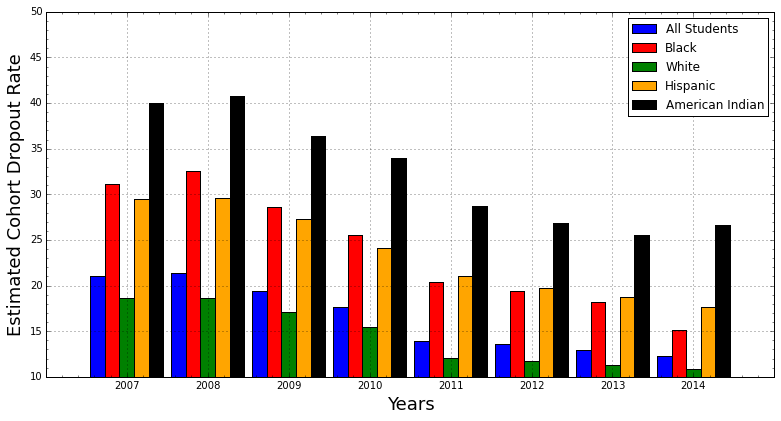

In [22]:
plot_aggregate_data((data2007_state, data2008_state, data2009_state, data2010_state, data2011_state, data2012_state, data2013_state, data2014_state), years=(2007,2008,2009,2010,2011,2012,2013,2014), column="Estimated Cohort Dropout Rate", population=("All Students", "Black","White","Hispanic","American Indian"), plot_type="bar", ylims=(10,50), outfile="dropout_rate_2007_2014.pdf")

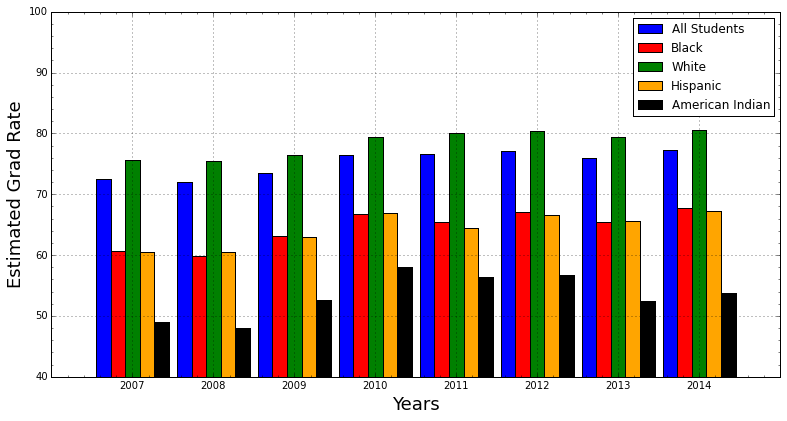

In [23]:
plot_aggregate_data((data2007_state, data2008_state, data2009_state, data2010_state, data2011_state, data2012_state, data2013_state, data2014_state), years=(2007,2008,2009,2010,2011,2012,2013,2014), column="Estimated Grad Rate", population=("All Students", "Black","White","Hispanic","American Indian"), plot_type="bar", ylims=(40,100), outfile="grad_rate_2007_2014.pdf")

/Users/Nick/anaconda/lib/python2.7/site-packages/matplotlib/backends/backend_pdf.py:2264: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  different = bool(ours != theirs)


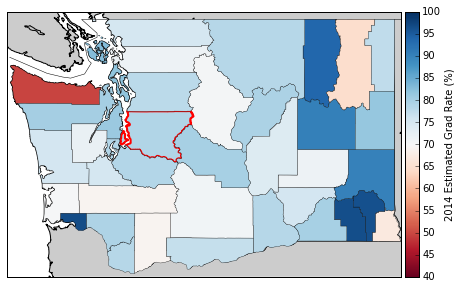

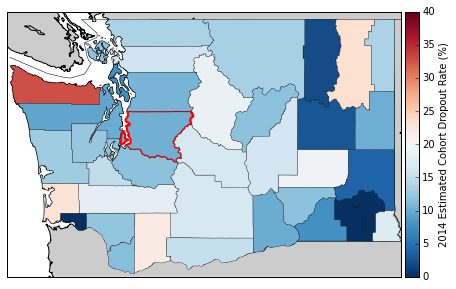

In [24]:
plot_county_data(data2014_county, "Estimated Grad Rate", "2014", vmin=40., vmax=100., cmap=plt.cm.RdBu, bounds = 'k', king_col="r", outfile="statewide_grad_rate.pdf")
plot_county_data(data2014_county, "Estimated Cohort Dropout Rate", "2014", vmax=40., cmap=plt.cm.RdBu_r, bounds = 'k', king_col="r", outfile="statewide_dropout_rate.pdf")

In [25]:
columns = ["Estimated Cohort Dropout Rate", "Estimated Grad Rate"]
diff_2007_2014 = get_differential(data2007_county, data2014_county, columns)

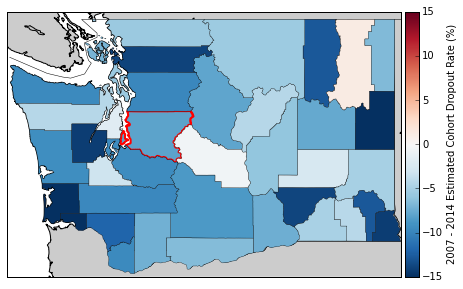

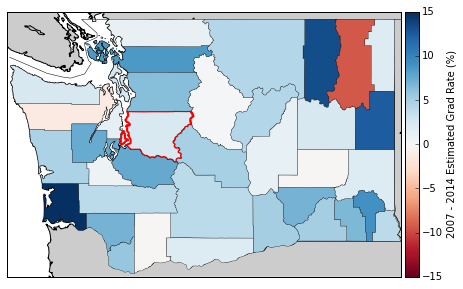

In [26]:
plot_county_data(diff_2007_2014, "Estimated Cohort Dropout Rate", "2007 - 2014", vmin=-15., vmax=15., cmap=plt.cm.RdBu_r, bounds = 'k', king_col="r", outfile="differential_dropout_rate.pdf")
plot_county_data(diff_2007_2014, "Estimated Grad Rate", "2007 - 2014", vmin=-15., vmax=15., cmap=plt.cm.RdBu, bounds = 'k', king_col="r", outfile="differential_grad_rate.pdf")